# Collision Detection Notebook
Implementation of 3D Collision Detection Algorithms

********************************************************************************************

In [1]:
import math
import shutil
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from primitives.triangle import Triangle
from scenes.scene import Scene
from scenes.render import render_scene
from utils.misc import get_floor

/Users/dipanjan/anaconda3/envs/Primitive-Intersection/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


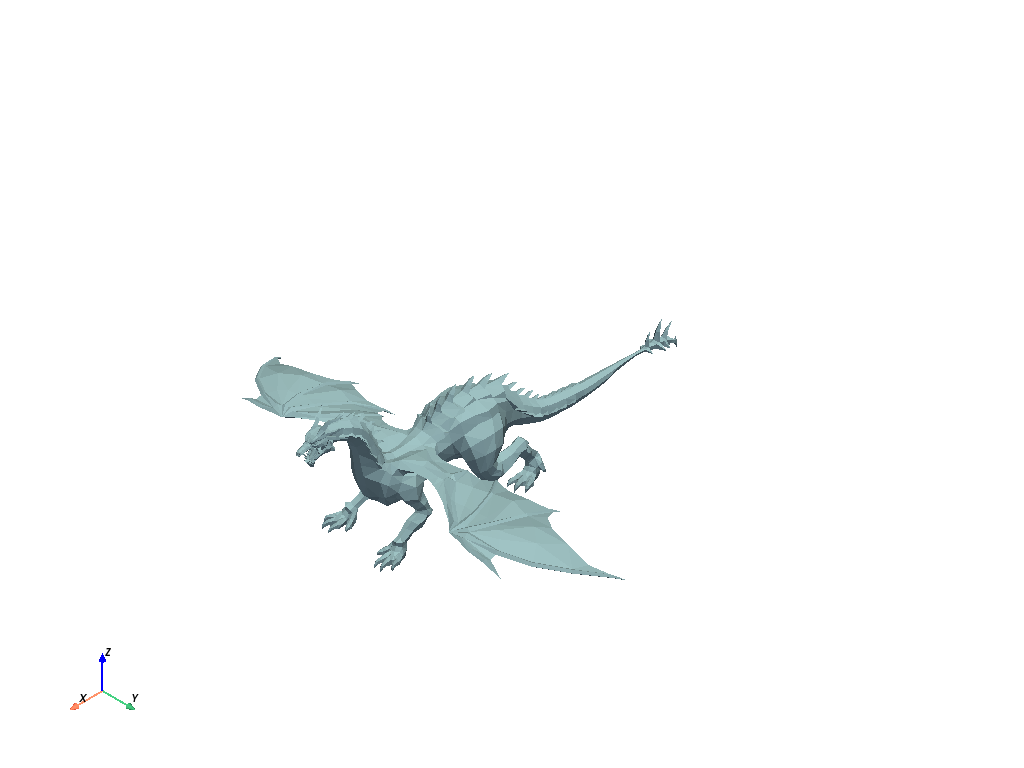

In [3]:
#load object

sphere_path = "objects/basic-shapes/sphere/sphere.obj"
cylinder_path = "objects/basic-shapes/cylinder/cylinder.obj"
rabbit = "objects/animals/rabbit/rabbit.obj"
carrot = "objects/objects/carrot/carrot.obj"
plane = "objects/vehicles/plane/plane.obj"
squirrel = "objects/divya/StarLogoNovaModels/mammals/squirrel/squirrel.obj"
tree = "objects/divya/StarLogoNovaModels/plants/broad_deciduous_tree_green_leaves/broad_deciduous_tree_green_leaves.obj"
ant = "objects/divya/StarLogoNovaModels/insects/ant/ant.obj"
fireball = "objects/objects/fireball/fireball.obj"
dragon = "objects/animals/dragon/dragon.obj"


file_path = dragon

path = Path(file_path).resolve()
mesh = pv.read(path)
mesh.plot()


In [4]:
# from pyvista import examples
#
# helmet_file = examples.gltf.download_damaged_helmet()
# texture = examples.download_dikhololo_night()
#
# pl = pv.Plotter()
# pl.import_gltf(helmet_file)
# pl.set_environment_texture(texture)
# pl.camera.zoom(1.7)
# pl.show()

In [5]:
# block = pv.read(helmet_file)
# mesh = block[0][0][0]
# mesh.plot(color='lightblue', show_edges=True, cpos='xy')

In [6]:
mesh = mesh.triangulate()
points = np.ascontiguousarray(mesh.points)
points

array([[-1.42032, -3.84453,  7.84104],
       [-1.20234, -3.05889,  7.51012],
       [-0.28715, -4.66891,  7.69354],
       ...,
       [ 2.48916, -0.38293,  8.22615],
       [ 2.7045 , -1.08761,  8.75081],
       [ 2.24759, -1.08761,  8.40765]], dtype=float32)

In [7]:
points = np.ascontiguousarray(mesh.points)
faces = mesh.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)

In [8]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [9]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64))
    objects.append(triangle)

objects

ListType[instance.jitclass.Triangle#11164e4f0<vertex_1:array(float64, 1d, A),vertex_2:array(float64, 1d, A),vertex_3:array(float64, 1d, A),centroid:array(float64, 1d, A),normal:array(float64, 1d, A)>]([<numba.experimental.jitclass.boxing.Triangle object at 0x1781d8e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x179235670>, <numba.experimental.jitclass.boxing.Triangle object at 0x1781d8e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x179235670>, <numba.experimental.jitclass.boxing.Triangle object at 0x1781d8e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x179235670>, <numba.experimental.jitclass.boxing.Triangle object at 0x1781d8e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x179235670>, <numba.experimental.jitclass.boxing.Triangle object at 0x1781d8e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x179235670>, <numba.experimental.jitclass.boxing.Triangle object at 0x1781d8e50>, <numba.experimental.jitclass.boxing.Tri

In [10]:
from utils.vectors import normalize

# Calculate the bounding box of the point cloud
centroid = mesh.center

min_p = np.min(vertices)-5

centroid, min_p

([-13.612534046173096, -1.0876045227050781, 7.944965001195669],
 -43.542808532714844)

In [11]:
# Define the camera parameters based on the bounding box
camera = centroid + np.array([0.0, 0.0, min_p])  # Position behind the centroid
look_at = normalize(centroid - camera)  # Looking towards the centroid
camera, look_at

(array([-13.61253405,  -1.08760452, -35.59784353]), array([0., 0., 1.]))

In [12]:
# Setup scene

# point camera
# look_at = np.array([0, 0, 1], dtype=np.float64)
# camera = np.array([1, 1, -5], dtype=np.float64)


# screen
width=300
height=300


# Initialise the scene with lights and camera
scene = Scene(look_at=look_at, camera=camera, width=width, height=height)

In [13]:
from accelerators.bvh import BoundedBox

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(4798, 4798)

In [14]:
from accelerators.bvh import build_bvh

# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)
ordered_prims = []
total_nodes = 0
split_method = 2 # 0: surface area heuristics, 1: mid-point, 2: equal parts
root, _, ordered_prims, total_nodes = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes, split_method)
# swap the primitives array with the ordered list
primitives = ordered_prims
# root node of the bvh tree
root

In [15]:
root.split_axis

0

In [16]:
from accelerators.bvh import BVHNode

def check_bound_intersects(this, other):
    # Checks overlap in x, y and z directions. If overlap is there in all three directions, the boxes intersect
    if this.min_point[0] <= other.max_point[0] and this.max_point[0] >= other.min_point[0] and \
       this.min_point[1] <= other.max_point[1] and this.max_point[1] >= other.min_point[1] and \
       this.min_point[2] <= other.max_point[2] and this.max_point[2] >= other.min_point[2]:
        return True
    return False

def check_bvh(node: BVHNode, primitives, depth=0, validate_bounds=False):
    assert node is not None, "Node in the BVH tree is null"
    if node.n_primitives > 0:    # leaf node
        assert node.n_primitives <= len(primitives), "Node has more primitives than it should"
        assert node.first_prim_offset < len(primitives), "Node first primitive offset is out of range"
        if validate_bounds:
            for i in range(node.first_prim_offset, node.first_prim_offset + node.n_primitives):
                assert node.bounds.intersects(primitives[i].bounds), "Primitive not within node bounds"
    else:   # interior node
        assert node.child_0 is not None, "Child 0 of the node is null"
        assert node.child_1 is not None, "Child 1 of the node is null"
        assert node.split_axis is not None, "Split axis of the node is None"
        check_bvh(node.child_0, primitives, depth+1, validate_bounds)
        check_bvh(node.child_1, primitives, depth+1, validate_bounds)
        if validate_bounds:
            assert check_bound_intersects(node, node.child_0.bounds), "Child 0 not within node bounds"
            assert check_bound_intersects(node, node.child_1.bounds), "Child 1 not within node bounds"

# Test the BVH tree
try:
    check_bvh(root, primitives, validate_bounds=False)
    print("BVH tree is correctly constructed.")
except AssertionError as e:
    print("BVH tree is not correctly constructed:", e)


BVH tree is correctly constructed.


In [17]:
# from accelerators.bvh import flatten_bvh_tree
#
# linear_bvh = flatten_bvh_tree(root, total_nodes)

In [18]:
from accelerators.bvh import LinearBVHNode

# create a linear representation of the bvh tree
linear_bvh = numba.typed.List()
for _ in range(total_nodes):
    linear_bvh.append(LinearBVHNode())
# linear_nodes = [LinearBVHNode() for _ in range(total_nodes)]
len(linear_bvh) # equals to the number of nodes in the original tree

9591

In [19]:
from accelerators.bvh import flatten_bvh

# linear bvh
# linear_bvh, _offset = flatten_bvh(linear_nodes, root, 0)
_offset = flatten_bvh(linear_bvh, root, [0])
len(linear_bvh), _offset

(9591, 0)

In [20]:
def test_linear_bvh(linear_bvh):
    for i in range(len(linear_bvh)):
        node = linear_bvh[i]
        # If leaf node, no further checks
        if node.n_primitives > 0:
            if node.primitives_offset is None:
                print("Leaf node's primitives_offset is None at index:", i)
                return False
            continue

        # Check if we're not exceeding list boundary
        if i + 1 >= len(linear_bvh):
            continue

        # The first child should be the very next node
        first_child = linear_bvh[i + 1]
        if first_child is None:
            print("First child node doesn't exist in Linear BVH at index:", i)
            return False

        # If node.second_child_offset isn't defined, no further checks
        if node.second_child_offset is None:
            continue

        # Check second child index isn't out of range
        if node.second_child_offset >= len(linear_bvh):
            print("Second child offset is out of range of Linear BVH. Node index:", i,
                  "Second child offset:", node.second_child_offset)
            return False

        # The second child should be at the specified offset
        second_child = linear_bvh[node.second_child_offset]

        if second_child is None:
            print("Second child node doesn't exist in Linear BVH at second_child_offset:", node.second_child_offset)
            return False

        # Check if axis is set (not None) for non-leaf nodes
        if node.axis is None:
            print("Node's axis is None at index:", i)
            return False

    # If we have checked all nodes without returning False, then the BVH is correct
    return True

test_result = test_linear_bvh(linear_bvh)

if test_result:
    print("Linear BVH is valid.")
else:
    print("Linear BVH is NOT valid.")


Linear BVH is valid.


In [21]:
def visualize_bvh_tree(linear_bvh):
    def print_node(node, level):
        indent = "    " * level
        print(f"{indent}Node: primitives_offset={node.primitives_offset}, Primitives={node.n_primitives}, Axis={node.axis}")

    def visualize_recursive(node_index, level):
        if node_index >= len(linear_bvh):
            return
        node = linear_bvh[node_index]
        print_node(node, level)

        if node.n_primitives == 0:
            visualize_recursive(node_index + 1, level + 1)
            visualize_recursive(node.second_child_offset, level + 1)

    print("BVH Tree Visualization:")
    visualize_recursive(0, 0)

# Call the visualization function with your linear_bvh data
visualize_bvh_tree(linear_bvh)


BVH Tree Visualization:
Node: primitives_offset=0, Primitives=0, Axis=0
    Node: primitives_offset=0, Primitives=0, Axis=0
        Node: primitives_offset=0, Primitives=0, Axis=0
            Node: primitives_offset=0, Primitives=0, Axis=0
                Node: primitives_offset=0, Primitives=0, Axis=0
                    Node: primitives_offset=0, Primitives=0, Axis=1
                        Node: primitives_offset=0, Primitives=0, Axis=1
                            Node: primitives_offset=0, Primitives=0, Axis=1
                                Node: primitives_offset=0, Primitives=0, Axis=1
                                    Node: primitives_offset=0, Primitives=0, Axis=0
                                        Node: primitives_offset=0, Primitives=0, Axis=0
                                            Node: primitives_offset=0, Primitives=0, Axis=0
                                                Node: primitives_offset=0, Primitives=1, Axis=0
                                        

In [22]:
from scenes.render import _render_scene

start = time.time()
# primitives = spheres, triangles
image = _render_scene(scene, objects, linear_bvh)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:53: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)
/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:53: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.0
0.33333333333333337
25.333333333333336
38.0
0.6666666666666667
12.666666666666668
50.66666666666667
1.0
63.0
13.0
1.3333333333333335
13.333333333333334
1.6666666666666667
13.666666666666666
2.0
63.33333333333333
75.33333333333333
14.000000000000002
2.3333333333333335
87.66666666666667
2.666666666666667
14.333333333333334
88.0
38.333333333333336
3.0
51.0
75.66666666666667
3.3333333333333335
3.6666666666666665
25.666666666666664
88.33333333333333
76.0
4.0
4.333333333333334
63.66666666666667
4.666666666666667
76.33333333333333
51.33333333333333
5.0
14.666666666666666
26.0
5.333333333333334
64.0
15.0
5.666666666666666
26.333333333333332
15.333333333333332
64.33333333333333
6.0
15.666666666666668
26.666666666666668
6.333333333333334
16.0
64.66666666666666
6.666666666666667
88.66666666666667
7.000000000000001
27.0
16.333333333333332
38.666666666666664
76.66666666666667
7.333333333333333
65.0
16.666666666666664
27.333333333333332
7.666666666666666
8.0
8.333333333333332
17.0
39.0
65.333333

In [23]:
# from numba_progress import ProgressBar
#
# num_iterations = scene.height
#
# start = time.time()
#
# with ProgressBar(total=num_iterations, ncols=80) as numba_progress1, ProgressBar(total=num_iterations, ncols=80) as numba_progress2:
#     image = render_scene(scene, objects, linear_bvh, (numba_progress1, numba_progress2))
#
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

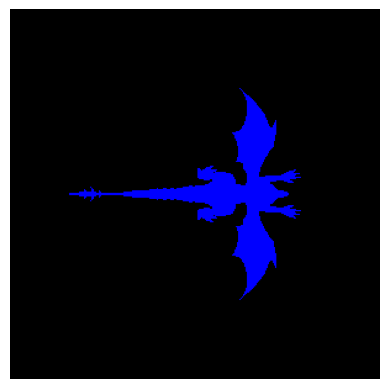

In [24]:
plt.imshow(image)
plt.axis('off')
plt.show()